Ellion Blessan <br>
ellionblessan@gmail.com <br>
Dataset: [Synthetic Image Dataset (Cats, Dogs, Bikes, Cars) | Kaggle](https://www.kaggle.com/datasets/zarkonium/synthetic-image-dataset-cats-dogs-bikes-cars)

# Importing dependencies

In [1]:
import tensorflow as tf
import zipfile
import os
import shutil
import pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rleonb","key":"7a755e4b1cd0edc5eeb3429063bda95d"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d zarkonium/synthetic-image-dataset-cats-dogs-bikes-cars

 98% 316M/321M [00:02<00:00, 136MB/s]
100% 321M/321M [00:02<00:00, 114MB/s]


# Preparing dataset

In [6]:
local_zip = 'synthetic-image-dataset-cats-dogs-bikes-cars.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [7]:
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
bikes_dir = os.path.join(base_dir, 'bikes/bikes')
cars_dir = os.path.join(base_dir, 'cars/cars')
cats_dir = os.path.join(base_dir, 'cats/cats')
dogs_dir = os.path.join(base_dir, 'dogs/dogs')

In [8]:
os.mkdir(train_dir)
os.mkdir(val_dir)

In [9]:
bikes_train = os.path.join(train_dir, 'bikes')
cars_train = os.path.join(train_dir, 'cars')
cats_train = os.path.join(train_dir, 'cats')
dogs_train = os.path.join(train_dir, 'dogs')

In [10]:
os.mkdir(bikes_train)
os.mkdir(cars_train)
os.mkdir(cats_train)
os.mkdir(dogs_train)

In [11]:
bikes_val = os.path.join(val_dir, 'bikes')
cars_val = os.path.join(val_dir, 'cars')
cats_val = os.path.join(val_dir, 'cats')
dogs_val = os.path.join(val_dir, 'dogs')

In [12]:
os.mkdir(bikes_val)
os.mkdir(cars_val)
os.mkdir(cats_val)
os.mkdir(dogs_val)

In [13]:
bikes_train_dir, bikes_val_dir = train_test_split(os.listdir(bikes_dir), test_size = 0.20)
cars_train_dir, cars_val_dir = train_test_split(os.listdir(cars_dir), test_size = 0.20)
cats_train_dir, cats_val_dir = train_test_split(os.listdir(cats_dir), test_size = 0.20)
dogs_train_dir, dogs_val_dir = train_test_split(os.listdir(dogs_dir), test_size = 0.20)

In [14]:
for file in bikes_train_dir:
  shutil.copy(os.path.join(bikes_dir, file), os.path.join(bikes_train, file))

for file in cars_train_dir:
  shutil.copy(os.path.join(cars_dir,file), os.path.join(cars_train,file))

for file in cats_train_dir:
  shutil.copy(os.path.join(cats_dir,file), os.path.join(cats_train,file))

for file in dogs_train_dir:
  shutil.copy(os.path.join(dogs_dir,file), os.path.join(dogs_train,file))

In [15]:
for file in bikes_val_dir:
  shutil.copy(os.path.join(bikes_dir, file), os.path.join(bikes_val, file))

for file in cars_val_dir:
  shutil.copy(os.path.join(cars_dir,file), os.path.join(cars_val,file))

for file in cats_val_dir:
  shutil.copy(os.path.join(cats_dir,file), os.path.join(cats_val,file))

for file in dogs_val_dir:
  shutil.copy(os.path.join(dogs_dir,file), os.path.join(dogs_val,file))

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   brightness_range = [1, 5],
                                   channel_shift_range = 5,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest'
                                   )

In [17]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = 'categorical'
                                                    )
 
validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size = (150, 150),
                                                        batch_size = 32,
                                                        class_mode = 'categorical'
                                                        )

Found 20000 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.


In [19]:
train_generator.class_indices

{'bikes': 0, 'cars': 1, 'cats': 2, 'dogs': 3}

# Model and plot

In [20]:
class trainCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.92):
      print('Accuracy over 92%, training is stopped')
      self.model.stop_training = True

callbacks = trainCallback()

In [21]:
tf.device('/device:GPU:0')

In [26]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2), 
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [29]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']
              )

In [30]:
history = model.fit(train_generator, 
                    epochs = 50, 
                    steps_per_epoch = train_generator.samples // 32,
                    validation_data = validation_generator, 
                    validation_steps = validation_generator.samples // 32,
                    verbose = 1,
                    callbacks = [callbacks]
                    )

Epoch 1/50
625/625 [==============================] - 147s 235ms/step - loss: 0.8079 - accuracy: 0.6076 - val_loss: 0.4776 - val_accuracy: 0.8151
Epoch 2/50
625/625 [==============================] - 146s 234ms/step - loss: 0.4374 - accuracy: 0.8164 - val_loss: 0.3044 - val_accuracy: 0.8814
Epoch 3/50
625/625 [==============================] - 146s 234ms/step - loss: 0.3486 - accuracy: 0.8582 - val_loss: 0.2532 - val_accuracy: 0.8992
Epoch 4/50
625/625 [==============================] - 146s 234ms/step - loss: 0.3098 - accuracy: 0.8709 - val_loss: 0.2676 - val_accuracy: 0.8872
Epoch 5/50
625/625 [==============================] - 146s 234ms/step - loss: 0.3009 - accuracy: 0.8760 - val_loss: 0.2424 - val_accuracy: 0.9062
Epoch 6/50
625/625 [==============================] - 147s 234ms/step - loss: 0.2850 - accuracy: 0.8799 - val_loss: 0.2535 - val_accuracy: 0.8976
Epoch 7/50
625/625 [==============================] - 146s 234ms/step - loss: 0.2691 - accuracy: 0.8896 - val_loss: 0.2174 -

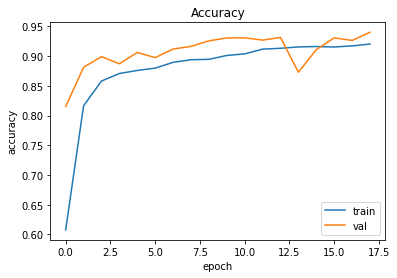

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

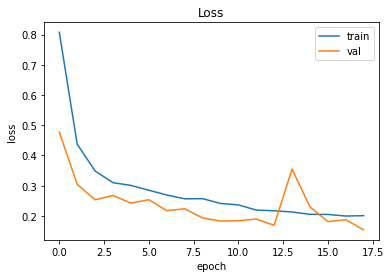

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Using the model to predict image

Saving 1001_img.jpg to 1001_img.jpg
1001_img.jpg
[[1. 0. 0. 0.]]
This is a bike


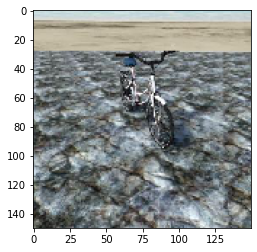

In [34]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150, 150))
 
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
 
  classes = model.predict(images, batch_size=10)

  print(fn)
  print(classes)
  
  if classes[0, 0] == 1:
    print('This is a bike')
  elif classes[0, 1] == 1:
    print('This is a car')
  elif classes[0, 2] == 1:
    print('This is a cat')
  else:
    print('This is a dog')

# Saving model to TFLite format

In [35]:
export_dir = '/content/saved_model'
tf.saved_model.save(model, export_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('synthetic-image-dataset-cats-dogs-bikes-cars.tflite')
tflite_model_file.write_bytes(tflite_model)

13900316